<a href="https://colab.research.google.com/github/saevrenk/qc/blob/main/xtb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Chemistry in the cloud using xTB code

This notebook walks you through performing semiempirical quantum chemistry calculations  by setting up [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html#) code from Grimme Lab. 

This notebook is inspired by Prof. Jensen's presentation at [here](https://youtu.be/KEIpJ50Jc0w).

# Imports and setup:

In [1]:
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()

In [84]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
%%capture
!mamba install -c conda-forge rdkit
!mamba install -c conda-forge xtb
!pip install py3Dmol

In [87]:
%%capture
!pip install jupyterlab

In [89]:
!jupyter labextension install jupyterlab_3dmol

-\|/-\|/-\|/-\|/-\|/-\Building jupyterlab assets (production, minimized)
-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PyMol

IPythonConsole.ipython_3d = True
import py3Dmol
import matplotlib.pyplot as plt
import subprocess
import re 
import pandas as pd

# Useful functions for working with rdkit and xtb:



In [6]:
def get_energy2(output): # in Hartree
  with open(output,'r') as file:
    data = file.read().replace('\n', '') 
  return float(data.split('TOTAL ENERGY')[1].split('Eh')[0])

def get_energy(output): # in Hartree
  output = str(output)
  energy = float(output.split('TOTAL ENERGY')[1].split('Eh')[0])
  return energy

def geo_converged(output):
  output = str(output)
  conv = output.split('GEOMETRY OPTIMIZATION CONVERGED')
  if not conv:
    return 0
  else:
    return 1
 
def show_mol(file_name):
  xyz=open(file_name, 'r').read()
  p = py3Dmol.view(width=400,height=400)
  p.addModel(xyz,'xyz')
  p.setStyle({'stick':{}})
  p.setBackgroundColor('0xeeeeee')
  p.zoomTo()
  p.show()

def smiles2xyz(smiles, file_name='temp.xyz'):
  # given a smiles string, write an xyz file to the directory
  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(mol)
  AllChem.MMFFOptimizeMolecule(mol)
  number_of_atoms = mol.GetNumAtoms()
  symbols = [a.GetSymbol() for a in mol.GetAtoms()]   
  with open(file_name, "w") as file:
    file.write(str(number_of_atoms)+"\n")
    file.write("title\n")
    conf = mol.GetConformers()[0]
    for atom,symbol in enumerate(symbols):
      p = conf.GetAtomPosition(atom)
      line = " ".join((symbol,str(p.x),str(p.y),str(p.z),"\n"))
      file.write(line)

def shell(cmd, shell=False):
  #Written by Jimmy Kromann
  if shell:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  else:
    cmd = cmd.split()
    p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  output, err = p.communicate()
  return output

# GFN2-xTB geometry optimization 
To do geometry optimization, we need initial structures of molecules, we can start with smiles and generate an approximate molecular geometry. 

As an example, lets use canonical SMILES strings for benzene and some of its derivatives:

In [7]:
names = ['benzene','aniline','phenol','benzoicacid']
smi = ['C1=CC=CC=C1  ','C1=CC=C(C=C1)N','C1=CC=C(C=C1)O','C1=CC=C(C=C1)C(=O)O']

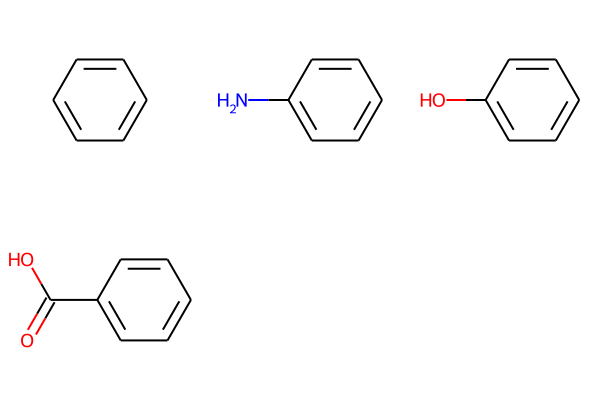

In [8]:
Draw.MolsToGridImage([Chem.MolFromSmiles(m) for m in smi])

smiles2xyz function returns the 3D geometry of the lowest energy conformer of molecule with a given SMILES string 

In [9]:
c = 0
for smiles in smi:
    smiles2xyz(smiles, names[c]+'.xyz')
    c += 1

In [90]:
# visualize initial xyz files
show_mol('aniline.xyz')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In the following shell we optimize geometry with GFN2-xTB (thight threshold) and check convergence. If geometry is converged save energy and optimized coordinates.


NOTE: xtb generates the following files in the current directory:
* **wbo**: Wiberg bond order printout
* **xtbopt.xyz**: optimized geometry in xyz format
* **xtbrestart**: binary restart file (default is true for restart!)
* **xtbtopo.mol**: optimized geometry in mol format

In [11]:
opt_level = 'tight'
energy = {}
for molname in names:
  output = shell('xtb '+molname+'.xyz  --opt '+opt_level)
  if geo_converged(output):
    energy[molname] = get_energy(output)
    shell('cp xtbopt.xyz '+molname+'_opt.xyz')

In [12]:
energy

{'aniline': -19.316691776239,
 'benzene': -15.879640657415,
 'benzoicacid': -26.173034346138,
 'phenol': -19.954146323168}

Visualize the optimized structures

In [13]:
# read xyz files into strings
benzene = open('benzene_opt.xyz', 'r').read()
aniline = open('aniline_opt.xyz', 'r').read()
phenol = open('phenol_opt.xyz', 'r').read()
benzoicacid = open('benzoicacid_opt.xyz', 'r').read()

In [91]:
# we can have a grid view py3Dmol:
view = py3Dmol.view(viewergrid=(2,2))
view.addModel(benzene,'xyz',viewer=(0,0))
view.addModel(aniline,'xyz',viewer=(0,1))
view.addModel(phenol,'xyz',viewer=(1,0))
view.addModel(benzoicacid,'xyz',viewer=(1,1))
view.setStyle({'stick':{}})
view.zoomTo()
view.render()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Lets try GFN2-xTB optimization on a larger molecule: 
Proteolysis-targeting chimeras (PROTACs) selectively degrade targeted proteins by the ubiquitin-proteasome system. Here is one of them (ACS Med. Chem. Lett. 2019, 10, 10, 1367–1369) 

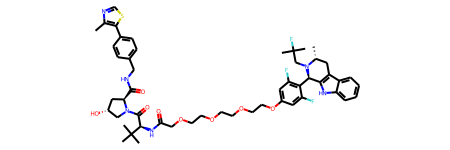

In [26]:
protac_smi = 'C[C@@H]1CC2=C(NC3=CC=CC=C23)[C@H](N1CC(C)(C)F)C1=C(F)C=C(OCCOCCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCC2=CC=C(C=C2)C2=C(C)N=CS2)C(C)(C)C)C=C1F'
protac = Chem.MolFromSmiles(protac_smi)
protac

Generate conformers and optimize them:

In [27]:
smiles2xyz(protac_smi, file_name='protac_conf0.xyz')

In [29]:

output = shell('xtb protac_conf0.xyz --opt '+opt_level)

In [31]:
shell('cp xtbopt.xyz protac_conf0_opt.xyz')

b''

Compare initial and optimized (gas phase) geometry:

In [92]:
protac_rdkit = open('protac_conf0.xyz','r').read()
protac_xtb = open('protac_conf0_opt.xyz','r').read()

view = py3Dmol.view(viewergrid=(1,2))
view.addModel(protac_rdkit,'xyz',viewer=(0,0))
view.addModel(protac_xtb,'xyz',viewer=(0,1))

view.setStyle({'stick':{}})
view.zoomTo()
view.render()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Gas phase optimization with xtb results in more compact structure. We can try optimization with a solvent model. The analytical linearized Poisson-Boltzmann (ALPB) model is envoked with the flag --alpb

In [39]:
!rm xtbrestart xtbopt.log xtbopt.xyz xtbtopo.mol

In [40]:
output = shell('xtb protac_conf0.xyz --opt --alpb'+opt_level)

In [41]:
shell('cp xtbopt.xyz protac_conf0_opt_solv.xyz')

b''

Solvation helps a little bit to open up the structure. 

In [93]:
protac_xtb_solv = open('protac_conf0_opt_solv.xyz','r').read()

view = py3Dmol.view(viewergrid=(1,3))
view.addModel(protac_rdkit,'xyz',viewer=(0,0))
view.addModel(protac_xtb,'xyz',viewer=(0,1))
view.addModel(protac_xtb_solv,'xyz',viewer=(0,2))

view.setStyle({'stick':{}})
view.zoomTo()
view.render()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Can monitor the energy and gradient in the optimizaton: 
(xtbopt.log belongs to the optimization with a solvent model)

In [47]:
energies = shell("grep energy xtbopt.log" )

In [82]:
e = str(energies).split('\\n')
energy = [float(line.split(' ')[2]) for line in e[0:-2]]
gradient_norm = [float(line.split(' ')[4]) for line in e[0:-2]]

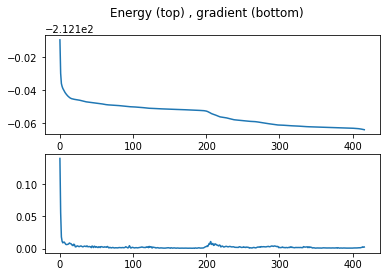

In [83]:
fig, axs = plt.subplots(2)
fig.suptitle('Energy (top) , gradient (bottom)')
axs[0].plot(range(0,len(energy)),energy)
axs[1].plot(range(0,len(energy)),gradient_norm)

The results indicate that conformational space need to be further explored with the proper generation of many conformers and subsequent minimizations. 